In [2]:
import numpy as np
import json
import os

save_folder = r"/mnt/d/phd/SPIQ/loaded_plate"

pinn_run = "pfnn_10min"
spinn_run = "pfnn_10min"

pinn_folder = os.path.join(save_folder, pinn_run)
spinn_folder = os.path.join(save_folder, spinn_run)


with open(pinn_folder + "/config.json") as f:
    pinn_config = json.load(f)
with open(spinn_folder + "/config.json") as f:
    spinn_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))


    return steps, values

losshistory_pinn = np.loadtxt(pinn_folder + "loss_history.dat")
losshistory_spinn = np.loadtxt(spinn_folder + "loss_history.dat")

PDE_loss_pinn = np.mean(losshistory_pinn[:, 1:3], axis=1)
Mat_loss_pinn = np.mean(losshistory_pinn[:, 3:5], axis=1) 
Residuals_pinn = losshistory_pinn[:, -1]

PDE_loss_spinn = np.mean(losshistory_spinn[:, 1:3], axis=1)
Mat_loss_spinn = np.mean(losshistory_spinn[:, 3:5], axis=1) 
Residuals_spinn = losshistory_spinn[:, -1]

pinn_steps_loaded = losshistory_pinn[:, 0]
spinn_steps_loaded = losshistory_spinn[:, 0]


metrics_pinn = [Residuals_pinn, PDE_loss_pinn, Mat_loss_pinn]
metrics_spinn = [Residuals_spinn, PDE_loss_spinn, Mat_loss_spinn]
metrics_names = ["Residuals", "PDE Loss", "Material Loss", "DIC Loss"]

# fig, ax1 = plt.subplots()
# ax1.plot(pinn_steps_loaded[10:], losshistory_pinn[10:, 1], label="Energy")
# ax2 = ax1.twinx()
# ax2.plot(spinn_steps_loaded[10:], spinn_loss[10:], label="Residual", color='orange')

# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/phd/SPIQ/loaded_plate/pfnn_10minconfig.json'

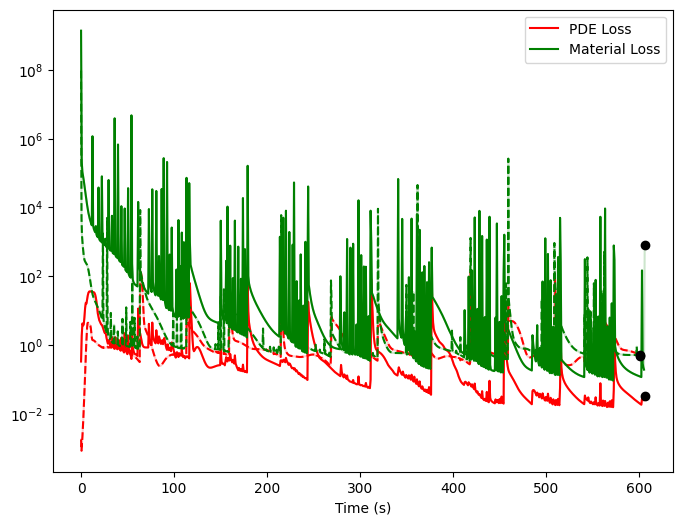

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


step_type = ["iteration", "time"][1]
metrics_idx = [1, 2]
t_pinn = pinn_config["elapsed"]
t_spinn = spinn_config["elapsed"]

spinn_steps = np.array(spinn_steps_loaded) 
pinn_steps = np.array(pinn_steps_loaded) 
if step_type == "time":
    spinn_steps = spinn_steps * t_spinn/spinn_steps_loaded[-1]
    pinn_steps = pinn_steps * t_pinn/pinn_steps_loaded[-1]
    speed_factor = t_pinn/t_spinn*len(spinn_steps)/len(pinn_steps)

def init_losshistory(ax, metrics_idx=[1, 2]):
    ax.set_yscale('log')
    ax.set_yscale('log')
    lines_pinn = []
    scatters_pinn = []
    lines_spinn = []
    scatters_spinn = []

    for idx in metrics_idx:
        ax.plot(pinn_steps, metrics_pinn[idx], alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
        ax.plot(spinn_steps, metrics_spinn[idx], alpha=0.2, color=['b', 'r', 'g', 'y'][idx])
        lines_pinn.append(ax.plot([], [], zorder=3, color=['b', 'r', 'g', 'y'][idx], label=metrics_names[idx])[0])
        lines_spinn.append(ax.plot([], [], zorder=3, color=['b', 'r', 'g', 'y'][idx], linestyle='--')[0])
        scatters_pinn.append(ax.scatter([], [], c='k', zorder=4))
        scatters_spinn.append(ax.scatter([], [], c='k', zorder=4))


    ax.legend()
    if step_type == "time":
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xlabel("Iterations")
    return lines_pinn, lines_spinn, scatters_pinn, scatters_spinn

def update_losshistory(iterations, lines_pinn, lines_spinn, scatters_pinn, scatters_spinns, metrics_idx=[1, 2]):
    if step_type == "time" and iterations > 0:
        spinn_iter = int(iterations * speed_factor)
    else:
        spinn_iter = iterations

    for i,idx in enumerate(metrics_idx):
        lines_pinn[i].set_data(pinn_steps[:iterations], metrics_pinn[idx][:iterations])
        scatters_pinn[i].set_offsets([pinn_steps[iterations], metrics_pinn[idx][iterations]])

        if spinn_iter < len(spinn_steps):
            lines_spinn[i].set_data(spinn_steps[:spinn_iter], metrics_spinn[idx][:spinn_iter])
            scatters_spinn[i].set_offsets([spinn_steps[spinn_iter], metrics_spinn[idx][spinn_iter]])


    return lines_pinn, lines_spinn, scatters_pinn, scatters_spinn

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
lines_pinn, lines_spinn, scatters_pinn, scatters_spinn = init_losshistory(ax, metrics_idx=metrics_idx)
update_losshistory(-1, lines_pinn, lines_spinn, scatters_pinn, scatters_spinn, metrics_idx=metrics_idx)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

In [10]:

logged_field = spinn_config["logged_fields"]
field_id = 6 #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy", 5: "Exx", 6: "Eyy", 7: "Exy"}
field_name = logged_field[str(field_id)]
_, V_spinn = read_data_file(spinn_folder + f"{field_name}_history.dat")
_, V_pinn = read_data_file(pinn_folder + f"{field_name}_history.dat")

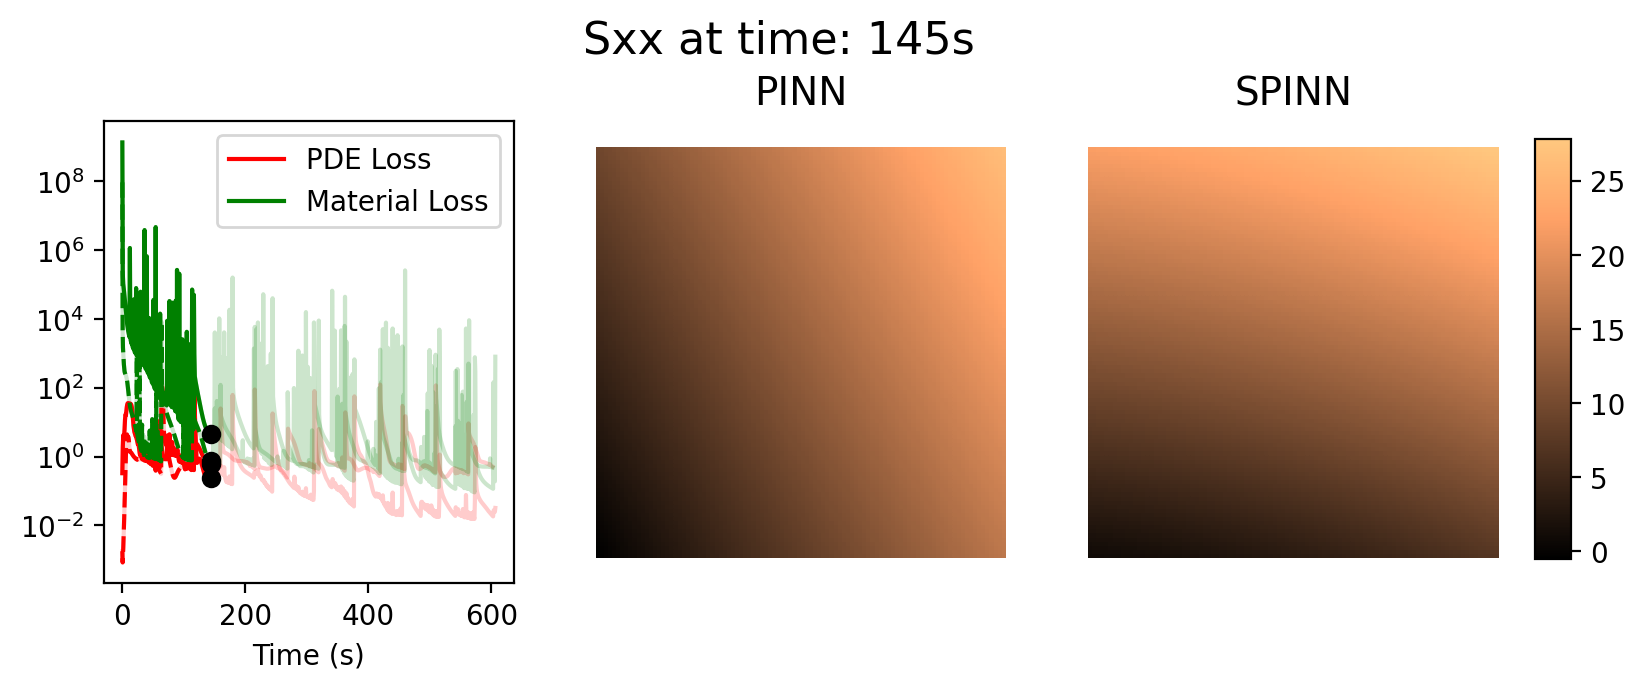

In [9]:
import matplotlib.colors as colors

def pcolor_plot(AX, X, Y, C, title,colormap="copper",norm=None):
    im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

i = 200
ngrid = 100

Xmesh, Ymesh = np.meshgrid(np.linspace(0, 1, ngrid), np.linspace(0, 1, ngrid), indexing='ij')
Xinput = np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1)))

cmin = np.min([np.min(V_pinn[i]), np.min(V_spinn[i])])
cmax = np.max([np.max(V_pinn[i]), np.max(V_spinn[i])])
Ux_norm = colors.Normalize(vmin=cmin, vmax=cmax) 

fig, ax = plt.subplots(1,3,figsize = (9,3),dpi = 200)


im_01 = pcolor_plot(ax[1], Xmesh, Ymesh, np.array(V_pinn[i]).reshape(ngrid,ngrid), "PINN", norm=Ux_norm)
im_02 = pcolor_plot(ax[2], Xmesh, Ymesh, np.array(V_spinn[i]).reshape(ngrid,ngrid), "SPINN", norm=Ux_norm)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbUx = fig.colorbar(im_01, ax=ax[0], cax=cax)
lines_pinn, lines_spinn, scatters_pinn, scatters_spinn =  init_losshistory(ax[0])
lines_pinn, lines_spinn, scatters_pinn, scatters_spinn = update_losshistory(i, lines_pinn, lines_spinn, scatters_pinn, scatters_spinn)

fig.suptitle(f"{field_name} at {step_type}: {pinn_steps[i]:.0f}{"s" if step_type == "time" else ""}", fontsize=16, y=1.05)
plt.show()
    

In [8]:
import matplotlib.animation as animation
from IPython.display import HTML
from itertools import chain

def animate(i, im_01, im_02, im_11, im_12, line_pinn, line_spinn, scatter_pinn, scatter_spinn, normdiff, cbdiff):

    if step_type == "time" and i > 0:
        spinn_iter = int(i * speed_factor)
    else:
        spinn_iter = i

    fig.suptitle(f"{field_name} at {step_type}: {pinn_steps[i]:.0f}{"s" if step_type == "time" else ""}", fontsize=16)

    im_01.set_array(np.array(V_pinn[i]).reshape(ngrid,ngrid).ravel())
    im_11.set_array((np.array(V_pinn[i]).reshape(ngrid,ngrid)-Ux_exact).ravel())
    if spinn_iter < len(spinn_steps):
        im_02.set_array(np.array(V_spinn[spinn_iter]).reshape(ngrid,ngrid).ravel())
        im_12.set_array((np.array(V_spinn[spinn_iter]).reshape(ngrid,ngrid)-Ux_exact).ravel())

    line_pinn, line_spinn, scatter_pinn, scatter_spinn = update_losshistory(i, line_pinn, line_spinn, scatter_pinn, scatter_spinn)
    
    diff = np.stack((np.array(V_pinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact,np.array(V_spinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact))
    abs_diff = np.abs(diff)
    cmax = abs_diff.max() if diff.max() > 0 else 0
    cmin = -abs_diff.max() if diff.min() < 0 else 0

    normdiff.vmin = cmin
    normdiff.vmax = cmax

    im_11.set_norm(normdiff)
    im_12.set_norm(normdiff)
    cbdiff.update_normal(im_12)

    return im_01, im_02, im_11, im_12, line_pinn, line_spinn, scatter_pinn, scatter_spinn, normdiff, cbdiff

def subsample_steps(steps, sub_factors):
    section_ends = [int(len(steps)*i/len(sub_factors)) for i in range(1, len(sub_factors)+1)]
    frame_steps_lists = []
    for i, step_size in enumerate(sub_factors):
        start = section_ends[i-1] if i > 0 else 0
        end = section_ends[i]
        frame_steps_lists.append(range(start, end, step_size))
    frame_steps = chain.from_iterable(frame_steps_lists)
    return frame_steps


steps = list(range(len(pinn_steps)))
sub_factors = [20]#list(range(1,6)) + [6]*4 #slower at the beginning
frame_steps = list(subsample_steps(steps, sub_factors))


anim = animation.FuncAnimation(fig, animate, fargs=(im_01, im_02, im_11, im_12, line_pinn, line_spinn, scatter_pinn, scatter_spinn, normdiff, cbdiff), frames=frame_steps, interval=100, repeat=False)
fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
HTML(anim.to_jshtml())
# anim.save('PINN_vs_SPINN_Ux.gif', writer='imagemagick', fps=5)

NameError: name 'im_11' is not defined

In [85]:
# anim.save('PINN_vs_SPINN_Ux.gif', writer='imagemagick', fps=5)
video_name = f"./videos/{field_name}_{step_type}_{pinn_run}_vs_{spinn_run}.mp4"
anim.save(video_name, writer='ffmpeg', fps=10)